# TDA @ HSE, YSDA 2024

## Homework 2

## Kudrjashov Sergej

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

In [280]:
from itertools import combinations, chain
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict
from dataclasses import dataclass

In [269]:
import matplotlib.pyplot as plt

In [3]:
from simplicialx.simplicial import SimplicialComplex

import pandas as pd

import numpy as np
np.set_printoptions(precision=3, edgeitems=12, linewidth=100)

### Task 1
#### Standard matrix reduction algorithm

**(2 points)** Consider the matrix of a binary relation $\mathbf{A}$. Construct the Dowker complexes $K$ and $L$ of $\mathbf{A}$ by constructing their boundary matrices. For each of complexes, compute Betti numbers of dimensions $0$ and $1$ using a standard matrix reduction algorithm you have impelemented for solving the problem 2 from Leaf 5.

In [3]:
A = np.load("./data/A.npy")
A

array([[1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0,

In [4]:
A.shape

(21, 64)

In [6]:
def reduce_boundary(boundary, frm=0):
    boundary = deepcopy(boundary)
    rows, cols = boundary.shape
# check for stop
    if frm >= min(rows, cols):
        return boundary
# iterate over rows and cols in search for 1
    for i in range(frm, rows):
        for j in range(frm, cols):
            if boundary[i, j] == 1:

                if j != frm:
                    boundary[:, [frm, j]] = boundary[:, [j, frm]]

                if i != frm:
                    boundary[[frm, i], :] = boundary[[i, frm], :]

                for z in range(frm + 1, rows):
                    if boundary[z, frm] == 1:
                        boundary[z, :] = (boundary[z, :] + boundary[frm, :]) % 2

                for z in range(frm + 1, cols):
                    if boundary[frm, z] == 1:
                        boundary[:, z] = (boundary[:, z] + boundary[:, frm]) % 2

                return reduce_boundary(boundary, frm + 1)

    return boundary

In [7]:
def swap_num(a, b):
    swaps = 1
    pos = b.index(a[0])
    try:
        for item in a[1:]:
            new_pos = b.index(item)
            if new_pos < pos:
                pos += 1
                swaps  *= -1
    except IndexError:
        return swaps
    return swaps

### Build complex on rows

In [8]:
simplices_L = []

for i, row in enumerate(A):
    sigma = np.nonzero(row)[0]

    if len(sigma) == 0:
        continue
    else:
        simplices_L.append(sigma)

In [9]:
simplices_L

[array([ 0,  2,  3,  4,  5,  9, 17]),
 array([ 5,  7, 15]),
 array([ 3,  4,  5,  8,  9, 10, 11, 19, 20, 26]),
 array([4]),
 array([5, 7]),
 array([ 0,  2, 11, 27, 32, 34]),
 array([ 0,  2,  4,  9, 10, 11, 19, 20, 21, 25, 26, 27, 32, 34, 42, 50]),
 array([ 4, 11, 15, 27, 31, 36, 38]),
 array([19]),
 array([19, 24, 26, 40, 42, 51, 60]),
 array([26]),
 array([50, 52]),
 array([31, 38, 52, 59]),
 array([60]),
 array([61, 63]),
 array([ 0,  8, 16, 24, 32, 40, 48, 57, 58]),
 array([26, 34, 42, 50, 56, 57, 59, 60, 61]),
 array([55, 61, 63])]

As we want to compute zero and first betti numbers -- therefore we only need simplices of $\dim\leq$ 2

In [10]:
simpl_set = set()

for item in chain.from_iterable([combinations(simplex, n) for n in range(1, 4) for simplex in simplices_L]):
    simpl_set.add(item)

In [11]:
simpl = defaultdict(list)

for i in simpl_set:
    simpl[len(i)-1].append(i)

In [12]:
boundary_matrices_L = {}
for k in range(2):
    boundary_matrices_L[k] = np.zeros((len(simpl[k]), len(simpl[k+1])))
    for i in range(len(simpl[k])):
        for j in range(len(simpl[k+1])):
            x = simpl[k][i]
            y = simpl[k+1][j]
            if not set(x).issubset(set(y)):
                continue
            boundary_matrices_L[k][i, j] = swap_num(x, y)
            

In [13]:
bounds_L = [reduce_boundary(matrix) for matrix in boundary_matrices_L.values()]

In [14]:
[boundary.shape for boundary in bounds_L]

[(39, 264), (264, 909)]

In [15]:
# we don't need zero-dim kernel as it's equal the number of nodes

z_0 = bounds_L[0].shape[0]
z_0

39

In [16]:
# compute image of the space of 1-boundaries

b_0 = np.sum([~np.all(bounds_L[0][i, :] == 0) for i in range(bounds_L[0].shape[0])])
b_0

38

In [17]:
betti_0 = z_0 - b_0
betti_0

1

$\beta_0=1$

In [18]:
# compute kernel in the space of 1-cycles

z_1 = np.sum([np.all(bounds_L[0][:, j] == 0) for j in range(bounds_L[0].shape[1])])
z_1

226

In [19]:
# compute image of the space of 2-boundaries

b_1 = np.sum([~np.all(bounds_L[1][i, :] == 0) for i in range(bounds_L[1].shape[0])])
b_1

220

In [20]:
betti_1 = z_1 - b_1
betti_1

6

$\beta_1=6$

### Now we have to do the same for the column based complex

In [21]:
simplices_K = []

for i, row in enumerate(A.T):
    sigma = np.nonzero(row)[0]

    if len(sigma) == 0:
        continue
    else:
        simplices_K.append(sigma)

In [22]:
simplices_K

[array([ 0,  5,  6, 18]),
 array([0, 5, 6]),
 array([0, 2]),
 array([0, 2, 3, 6, 7]),
 array([0, 1, 2, 4]),
 array([1, 4]),
 array([ 2, 18]),
 array([0, 2, 6]),
 array([2, 6]),
 array([2, 5, 6, 7]),
 array([1, 7]),
 array([18]),
 array([0]),
 array([ 2,  6,  9, 10]),
 array([2, 6]),
 array([6]),
 array([10, 18]),
 array([6]),
 array([ 2,  6, 10, 11, 19]),
 array([5, 6, 7]),
 array([ 7, 14]),
 array([ 5,  6, 18]),
 array([ 5,  6, 19]),
 array([7]),
 array([ 7, 14]),
 array([10, 18]),
 array([ 6, 10, 19]),
 array([18]),
 array([ 6, 13, 19]),
 array([10]),
 array([13, 14]),
 array([20]),
 array([19]),
 array([18, 19]),
 array([18]),
 array([14, 19]),
 array([10, 16, 19]),
 array([17, 19, 20]),
 array([17, 20])]

In [23]:
simpl_set = set()

for item in chain.from_iterable([combinations(simplex, n) for n in range(1, 4) for simplex in simplices_K]):
    simpl_set.add(item)

In [24]:
simpl = defaultdict(list)

for i in simpl_set:
    simpl[len(i)-1].append(i)

In [25]:
boundary_matrices_K = {}
for k in range(2):
    boundary_matrices_K[k] = np.zeros((len(simpl[k]), len(simpl[k+1])))
    for i in range(len(simpl[k])):
        for j in range(len(simpl[k+1])):
            x = simpl[k][i]
            y = simpl[k+1][j]
            if not set(x).issubset(set(y)):
                continue
            boundary_matrices_K[k][i, j] = swap_num(x, y)

In [26]:
bounds_K = [reduce_boundary(matrix) for matrix in boundary_matrices_K.values()]

In [27]:
[boundary.shape for boundary in bounds_K]

[(18, 49), (49, 38)]

In [28]:
# we don't need zero-dim kernel as it's equal the number of nodes

z_0 = bounds_K[0].shape[0]
z_0

18

In [29]:
# compute image of the space of 1-boundaries

b_0 = np.sum([~np.all(bounds_K[0][i, :] == 0) for i in range(bounds_K[0].shape[0])])
b_0

17

In [30]:
betti_0 = z_0 - b_0
betti_0

1

$\beta_0=1$

In [31]:
# compute kernel in the space of 1-cycles

z_1 = np.sum([np.all(bounds_K[0][:, j] == 0) for j in range(bounds_K[0].shape[1])])
z_1

32

In [32]:
# compute image of the space of 2-boundaries

b_1 = np.sum([~np.all(bounds_K[1][i, :] == 0) for i in range(bounds_K[1].shape[0])])
b_1

26

In [33]:
betti_1 = z_1 - b_1
betti_1

6

$\beta_1=6$

As supposed we got the same result, however matrices were much smaller -- it's useful to choose the smaller dimension for complex creation

### Task 2

#### Higher-order Laplacian,  representatives of homology classes

**(1 point)** For the Dowker complexes $K$ and $L$ construct higher-order Laplacian matrices $\mathbf{L}_0$ and $\mathbf{L}_1$ using oriented boundary matrices using the definition on page 22 of Lecture 8. For each of complexes, compute Betti numbers of dimension $0$ and $1$ by their eigendecomposition, and plot eigenvalues of $\mathbf{L}_0$ and $\mathbf{L}_1$.

**(1 point)** Localize several 1-dimensional homology classes of $K$ and $L$ by plotting the harmonic eigenvectors of $\mathbf{L}_1$ over the edges of $K$ and $L$ (see Seminar 10).

Define function to create n-dim ordered boundary matrices

In [35]:
def create_boundary_matrices(simplices, dim = 2):

    simpl_set = set()

    for item in chain.from_iterable([combinations(simplex, n) for n in range(1, dim+2) for simplex in simplices]):
        simpl_set.add(item)

    simpl = defaultdict(list)
    
    for i in simpl_set:
        simpl[len(i)-1].append(i)

    simpl = {k: np.array(sorted(v)) for k,v in simpl.items()}

    boundary_matrices = {}
    for k in range(dim):
        boundary_matrices[k] = np.zeros((len(simpl[k]), len(simpl[k+1])))
        for j in range(len(simpl[k+1])):
            sign = -1
            for l in range(k+2):
                sign *= -1
                for i in range(len(simpl[k])):
                    x = simpl[k][i]
                    y = simpl[k+1][j][np.arange(len(simpl[k+1][j]))!=l]
                    if np.all(x == y):
                        boundary_matrices[k][i, j] = sign
                        break

    return boundary_matrices, simpl

In [111]:
def plot_harmonic_representative(number: int) -> None:
    
    plt.figure(figsize=(15,15), dpi=100)
    plt.scatter(X[cmplx.simplices[0].reshape(-1)][:,0], X[cmplx.simplices[0].reshape(-1)][:,1], c="b", s=25)
    plt.xlim(-0.5, 10.5)
    plt.ylim(-0.5, 10.5)
    
    # edges
    for edge in cmplx.simplices[1]:
        plt.plot(X[edge][:,0], X[edge][:,1], c="b", alpha=0.25, linewidth=1)
    
    # triangles
    for triangle in cmplx.simplices[2]:
        t = plt.Polygon(X[triangle], color="b", alpha=0.1, linewidth=0)
        plt.gca().add_patch(t)
        
    for vertex in cmplx.simplices[0]:
            plt.annotate(vertex[0], (X[vertex,0]-0.2, X[vertex,1]-0.15), fontsize=12)
    
    # plot eigenvector for second zero eigenvalue
    counter=-1
    for k in range(len(eig)):
        
        if np.isclose(eig[k], 0):
            counter +=1
            if counter == number:
                eigvec_norm = np.abs(eigenvec[:,k]) / np.abs(eigenvec[:,k]).max()
                for i, edge in enumerate(cmplx.simplices[1]):
                    plt.plot(X[edge][:,0], X[edge][:,1], c="y", alpha=eigvec_norm[i], linewidth=5*eigvec_norm[i], 
                             label="({}, {}): {:.2f}".format(edge[0], edge[1], np.abs(eigenvec[i,k])))
                break
    
    plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.0))
    
    plt.show()

Construct boundaries for L

In [36]:
boundaries_L, simpl_L = create_boundary_matrices(simplices_L)

$\mathbf L_0$ consists of upper laplacian only as the lower is just 0

In [37]:
L0 = boundaries_L[0]@boundaries_L[0].T

In [38]:
eig = np.linalg.eigvals(L0)

$\beta_0$

In [39]:
np.isclose(np.zeros_like(eig), eig).sum()

1

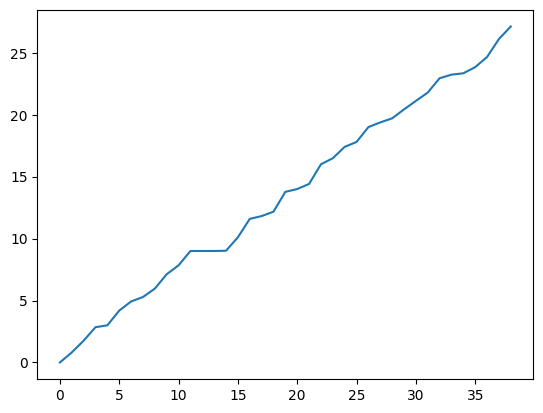

In [40]:
plt.plot(sorted(eig))

$\mathbf L_1$

In [41]:
L1 = boundaries_L[0].T@boundaries_L[0] + boundaries_L[1]@boundaries_L[1].T

In [92]:
eig, eigenvec = np.linalg.eig(L1)

$\beta_1$

In [93]:
np.isclose(np.zeros_like(eig), eig).sum()

6

/home/xenos/maga/venv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/xenos/maga/venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


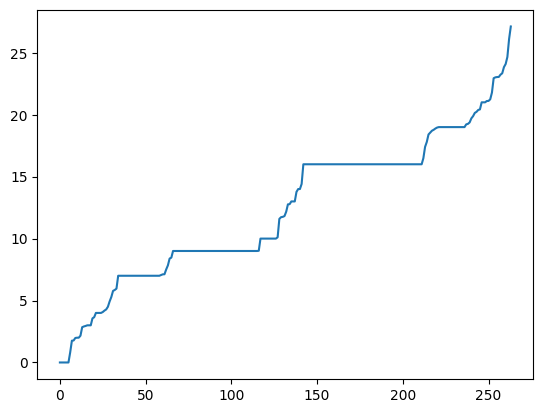

In [94]:
plt.plot(sorted(eig))

In [65]:
cmplx = SimplicialComplex()

for i in simplices_L:
    cmplx.add(i)

In [90]:
X = np.random.rand(64, 2) * 10

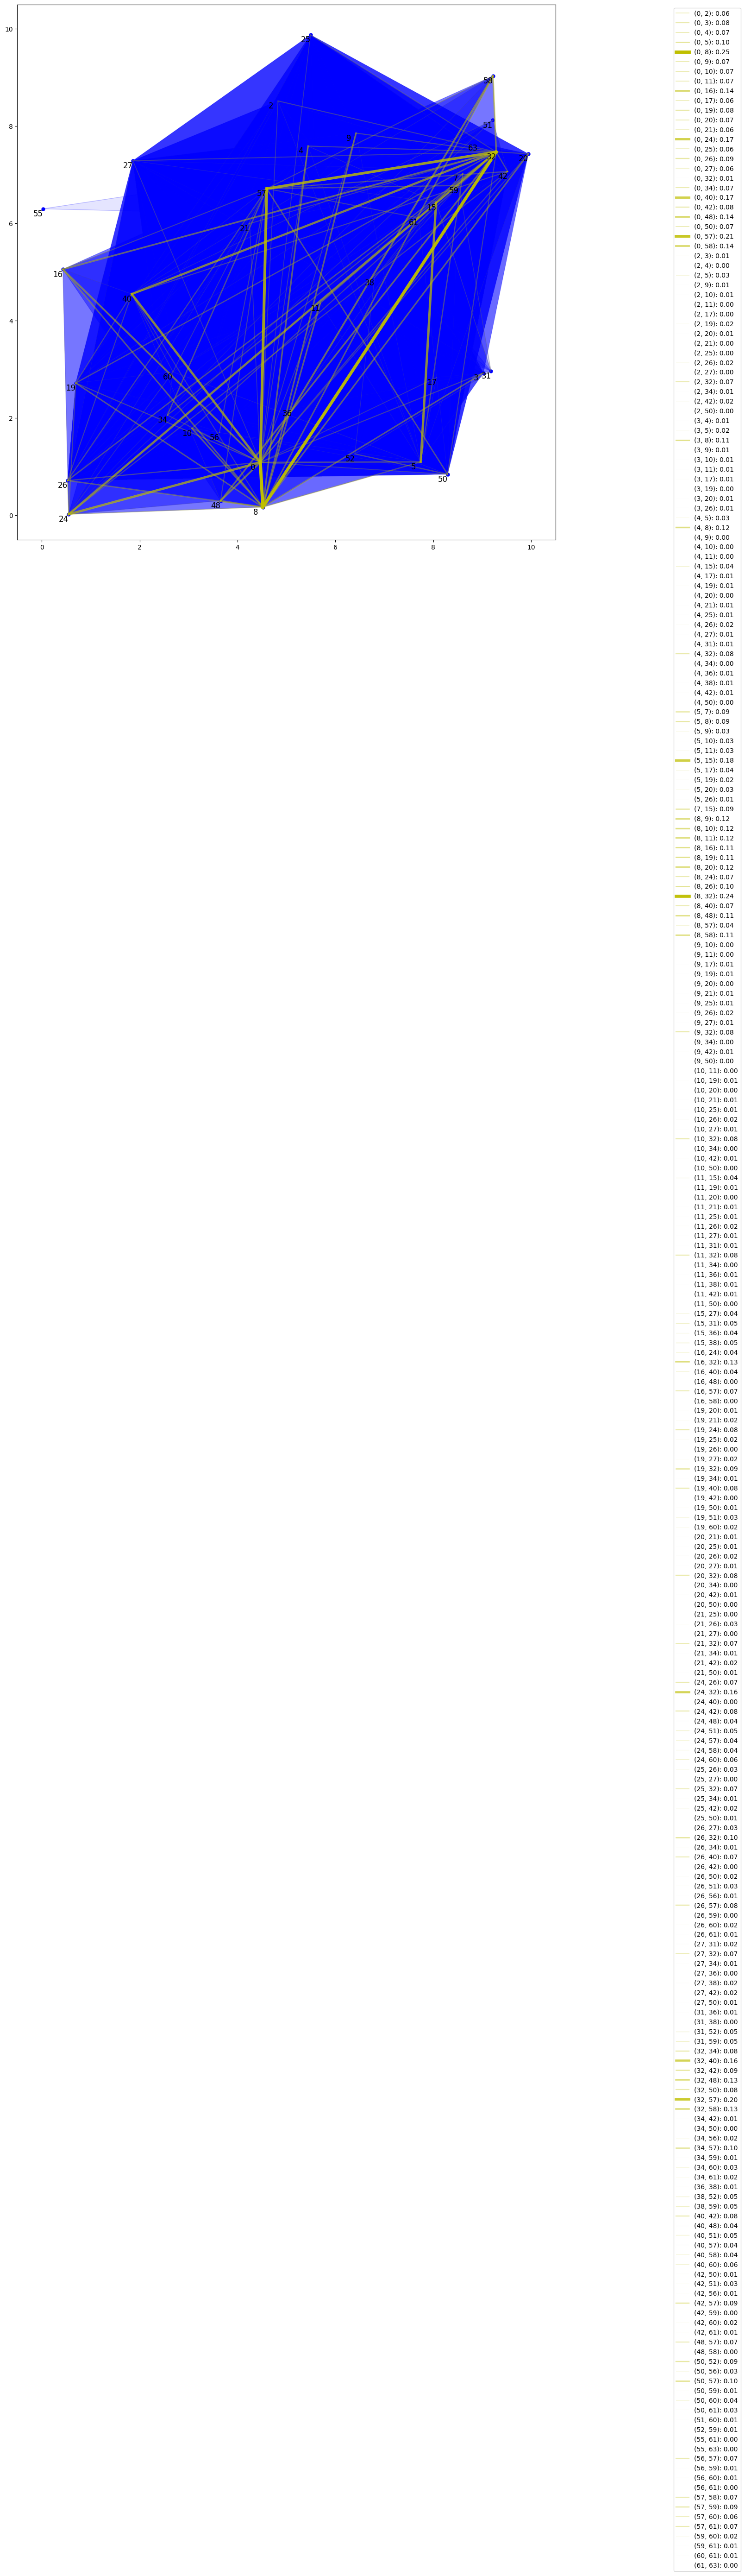

In [112]:
plot_harmonic_representative(0)

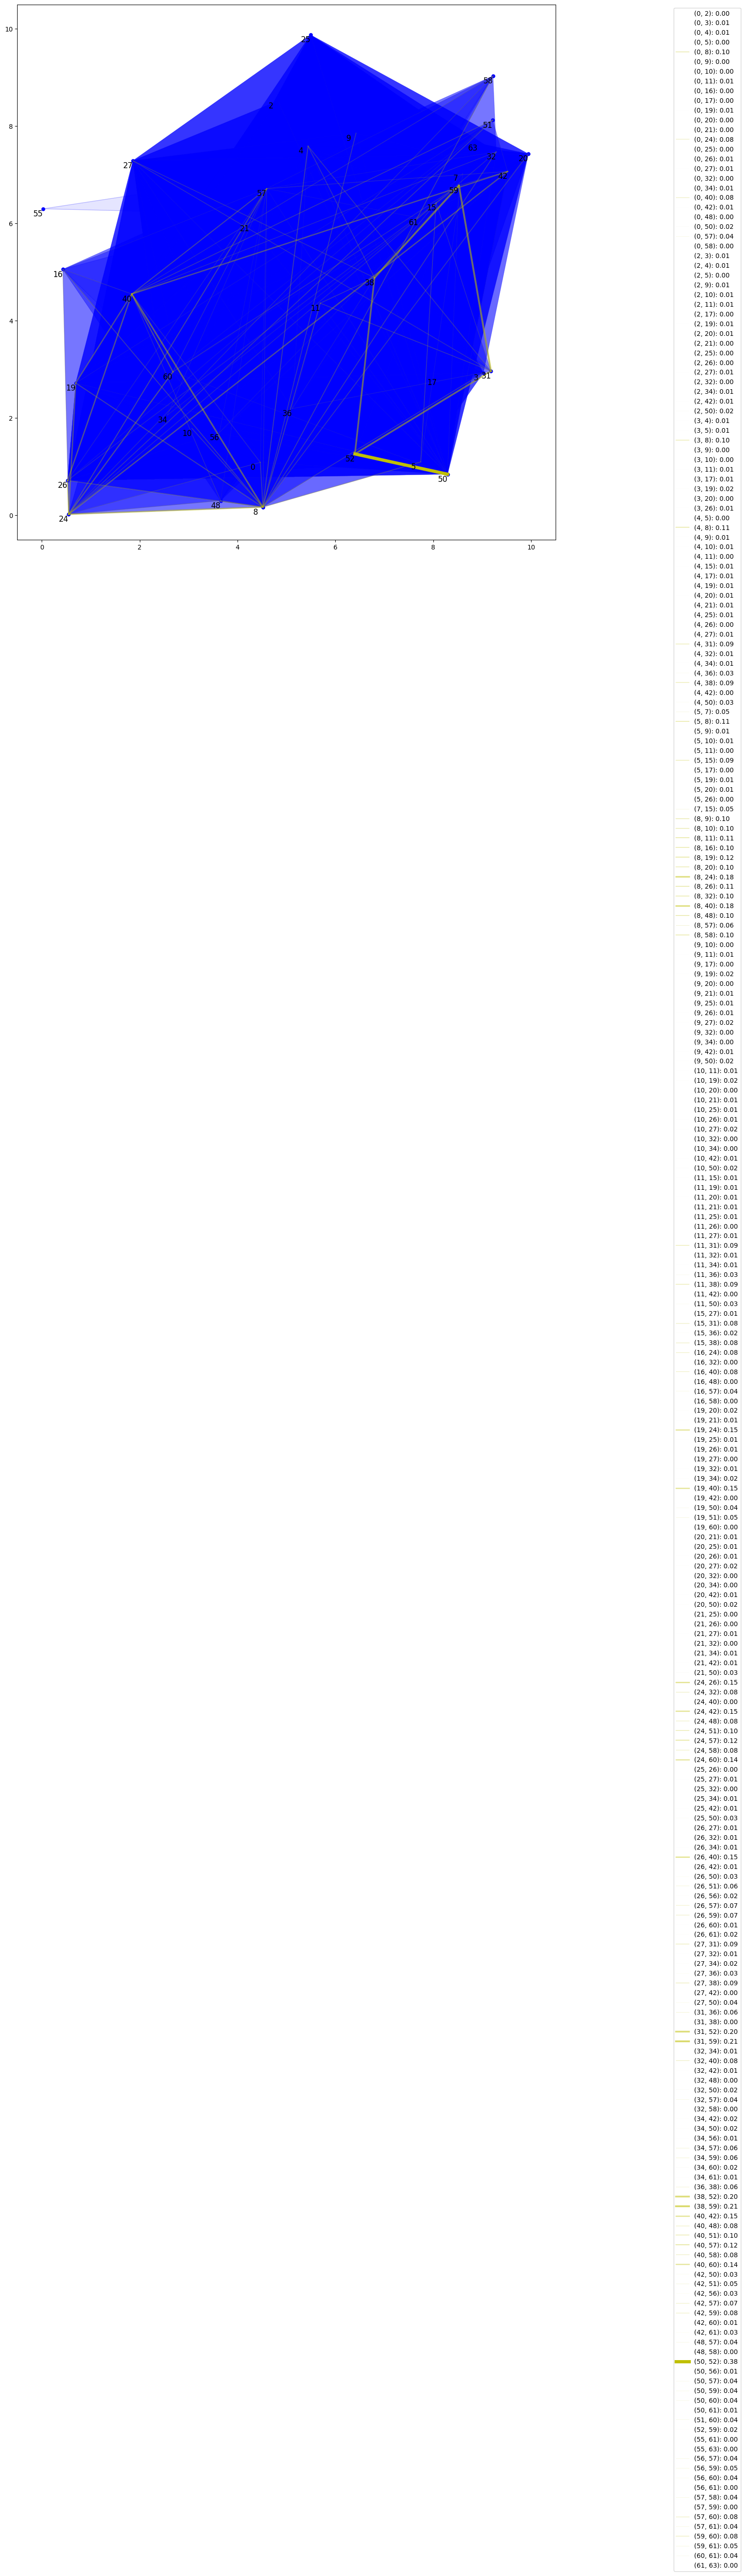

In [113]:
plot_harmonic_representative(2)

Construct boundaries for K

In [114]:
boundaries_K, simpl_K = create_boundary_matrices(simplices_K)

$\mathbf L_0$

In [133]:
L0 = boundaries_K[0]@boundaries_K[0].T

In [116]:
eig = np.linalg.eigvals(L0)

$ \beta_0 $

In [117]:
np.isclose(np.zeros_like(eig), eig).sum()

1

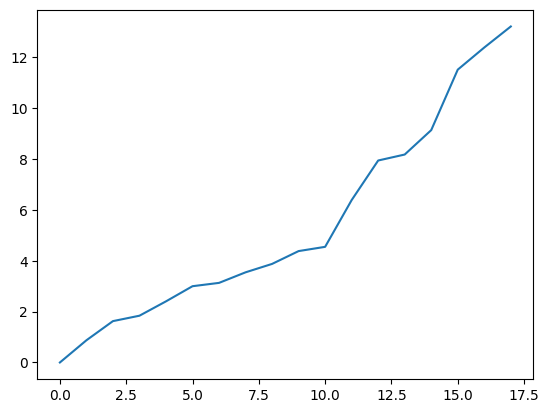

In [118]:
plt.plot(sorted(eig))

$\mathbf L_1$

In [119]:
L1 = boundaries_K[0].T@boundaries_K[0] + boundaries_K[1]@boundaries_K[1].T

In [123]:
eig, eigenvec = np.linalg.eig(L1)

$\beta_1$

In [124]:
np.isclose(np.zeros_like(eig), eig).sum()

6

/home/xenos/maga/venv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/xenos/maga/venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


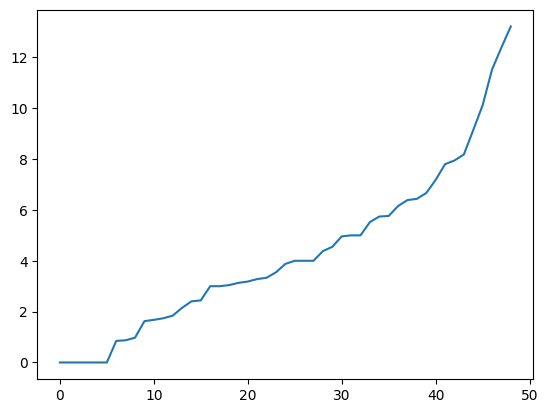

In [125]:
plt.plot(sorted(eig))

In [126]:
cmplx = SimplicialComplex()

for i in simplices_K:
    cmplx.add(i)

In [128]:
X = np.random.rand(21, 2) * 10

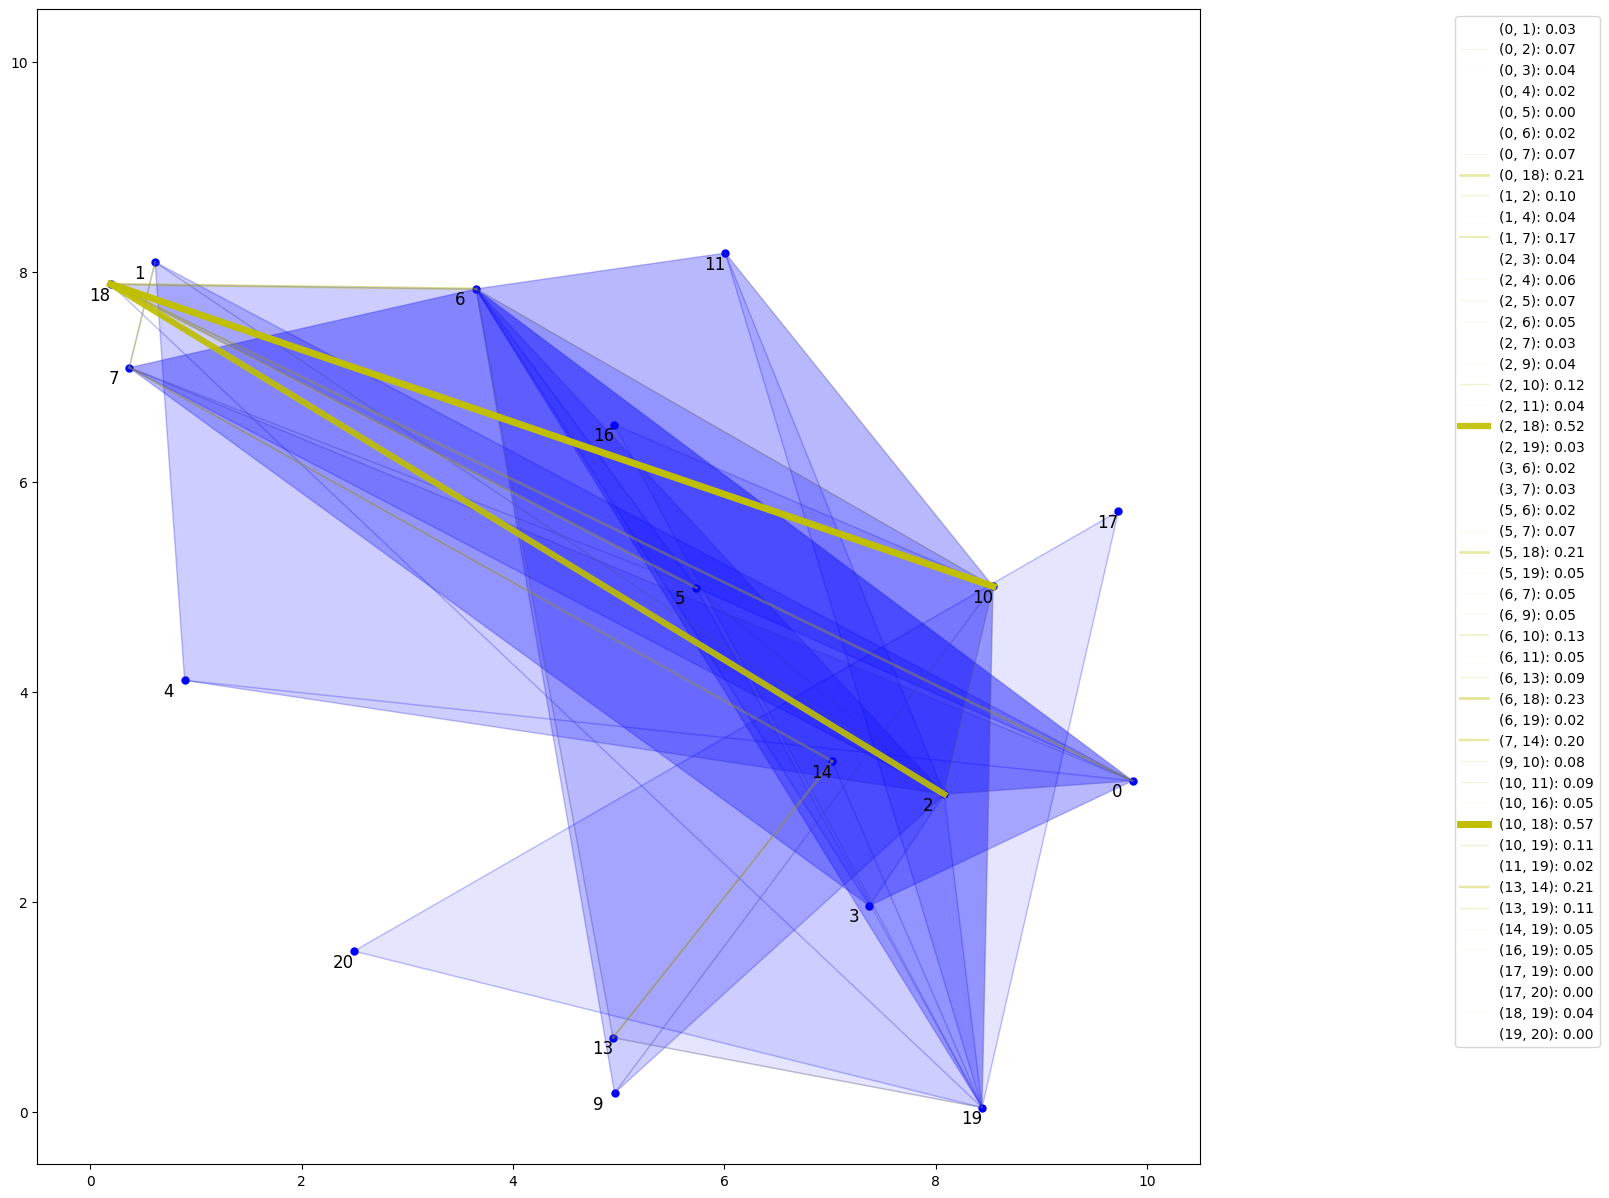

In [129]:
plot_harmonic_representative(0)

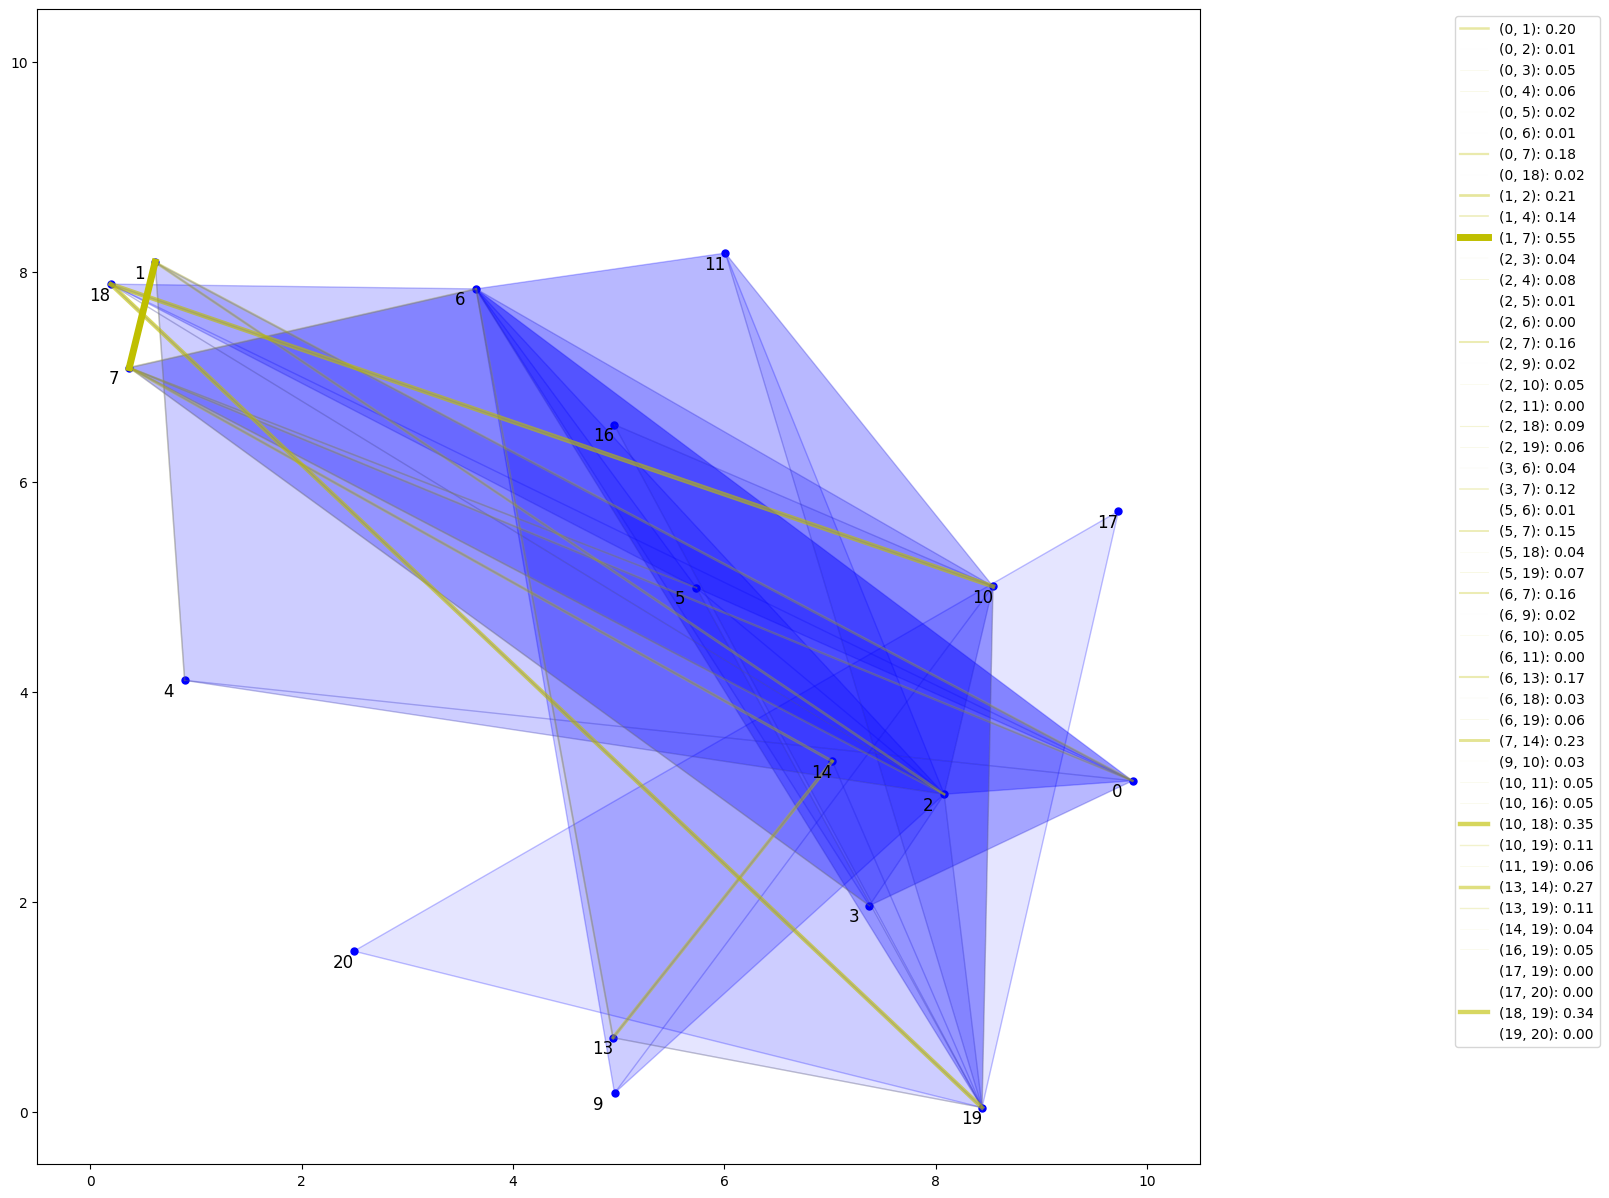

In [131]:
plot_harmonic_representative(2)

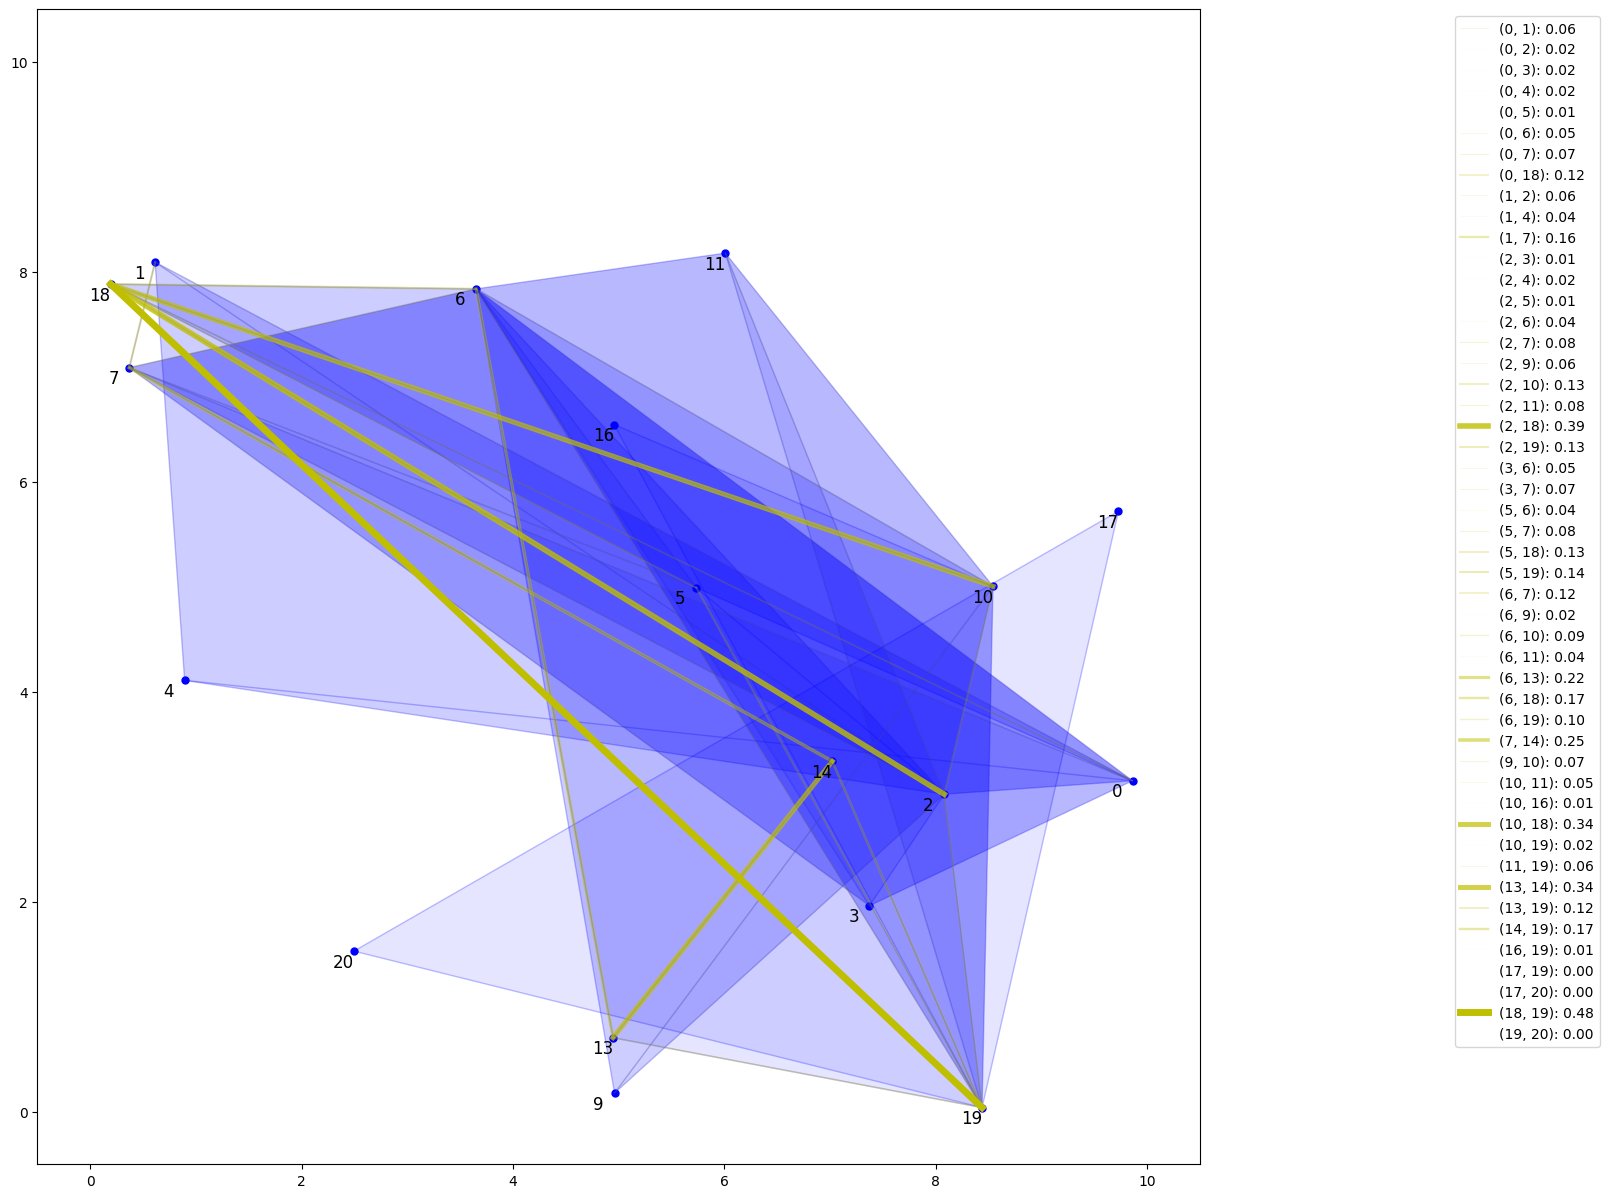

In [132]:
plot_harmonic_representative(5)

### Task 3

#### Simplicial network science

Consider the functional connectome dataset, consisting of Alzheimer decease-affected persons and control group matrices of Pearson's correlation coefficient.

**(1 point)** Compute the $k$-th Betti number curves of dimensions $0$ and $1$. Compute mean simplicial degrees and centralities curves introduces on Lecture 8 using the `simplicialx` library. For each patient groups, plot the means of obtained curves along with their confidence intervals.

**(1 point)** For each of obtained curves, along with their union, solve the binary classification problem with 5-fold cross validation using classifiers from:
- `sklearn` library,
- 1D CNN or MLP-Mixer model, https://arxiv.org/abs/2105.01601.

In [12]:
import seaborn as sns

In [5]:
X = np.load("./data/X_OASIS3_MSDL_pearson-r.npy")
y = np.load("./data/y_OASIS3.npy") # 0 - controls, 1 - Alzheimer decease-affected
X.shape, y.shape

((1029, 39, 39), (1029,))

Firstly we need to define a transformation of correlation matrix into some proper distance matrix in metric space. Although it's not a trivial question and we could use some kernel here too -- the most common solution is to use the following transformation:

$M_{ij} = 1 - |C_{ij}|$

In [246]:
np.unique(y)

array([0, 1])

<Axes: >

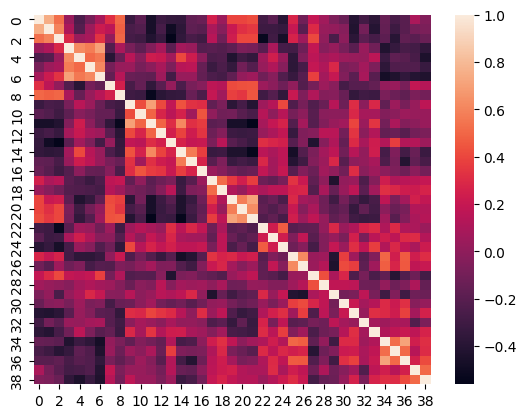

In [13]:
sns.heatmap(X[0])

In [66]:
transform = np.frompyfunc(lambda x: 1 - abs(x), nin=1, nout=1,)

In [139]:
D = transform(X,).astype(np.float16)

In [150]:
np.max(D)

1.0

In [282]:
filtration = np.linspace(0, 1, 15)

In [283]:
filtration

array([0.   , 0.071, 0.143, 0.214, 0.286, 0.357, 0.429, 0.5  , 0.571, 0.643, 0.714, 0.786, 0.857,
       0.929, 1.   ])

In [284]:
def compute_betti(cmplx: SimplicialComplex, betti_dict: dict, k: int):
    '''
    cmplx: Simplicial Complex
    betti_dict: dictionary to add to
    k: order of highest betti number to compute
    '''

    for j in range(k+1):
            try:
                betti = cmplx.betti_number(j)
            except ValueError:
                betti = 0
            betti_dict[j].append(betti)

    return betti_dict

In [379]:
class TDAFeatures:
    def __init__(self):
        self.betti = defaultdict(list)
        self.degree: list = []
        self.closeness_centrality: list = []
        self.betweenness_centrality: list = []
    
    def _check_dict(self, dict_values):

        if bool(dict_values):
            return [*dict_values]
        return [0]

    def update_tda_feats(self, cmplx):
    
        self.betti = compute_betti(cmplx, self.betti, k=1) # get zero and first betti
        self.degree.append(np.mean(cmplx.simplex_degree(k=1, p=1))) # mean node-edge simplex degree
        self.closeness_centrality.append(np.mean(
            self._check_dict(
                cmplx.simplex_closeness_centrality(p=1, q=0).values()
            ))) # edge-node close centrality
        self.betweenness_centrality.append(np.mean(
            self._check_dict(
                cmplx.simplex_betweenness_centrality(p=1, q=0).values()
            ))) # edge-node between centrality

    def update_to_last(self):

        for b in self.betti:
            self.betti[b] += [self.betti[b][-1]]
        self.degree += [self.degree[-1]]
        self.closeness_centrality += [self.closeness_centrality[-1]]
        self.betweenness_centrality += [self.betweenness_centrality[-1]]

In [381]:
cmplx = SimplicialComplex()
tda_feats = TDAFeatures()

for i in range(D[0].shape[0]):
    cmplx.add([i])

tda_feats.update_tda_feats(cmplx)

However, current implementation takes too long to process -- especially taking the dataset size into account

In [383]:
for i in tqdm(filtration[1:]):
    cur = (D[0] <= i)*D[0]
    tmp = cmplx.from_graph(cur)
    if len(tmp.simplices) == len(cmplx.simplices):
        if all([np.array_equal(a, b) for a,b in zip(tmp.simplices, cmplx.simplices)]):
            cmplx = tmp
            tda_feats.update_to_last()
            continue
    cmplx = tmp
    tda_feats.update_tda_feats(cmplx=cmplx)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:01<00:00,  4.37s/it]


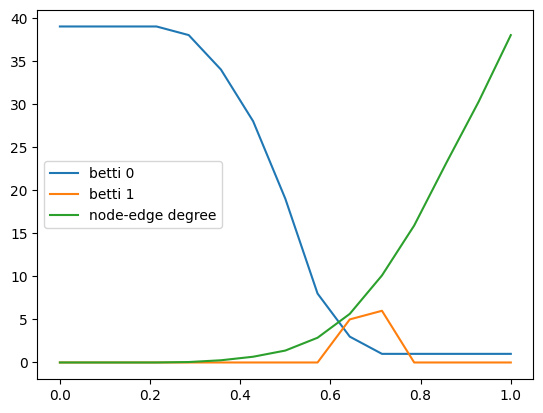

In [387]:
plt.plot(filtration, tda_feats.betti[0], label="betti 0")
plt.plot(filtration, tda_feats.betti[1], label="betti 1")
plt.plot(filtration, tda_feats.degree, label="node-edge degree")
plt.legend()

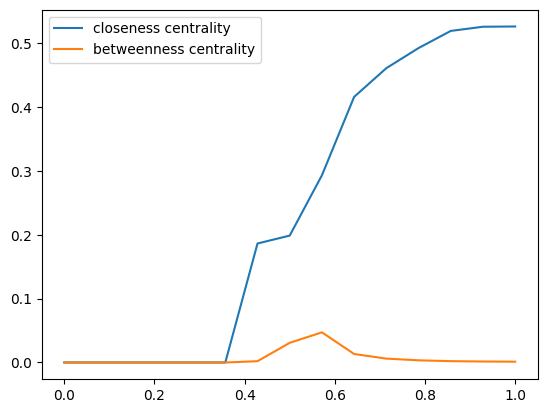

In [388]:
plt.plot(filtration, tda_feats.closeness_centrality, label="closeness centrality")
plt.plot(filtration, tda_feats.betweenness_centrality, label="betweenness centrality")
plt.legend()

In [389]:
def process_dataset(dataset, filtration):

    stats = []

    for participant in tqdm(dataset):
    
        cmplx = SimplicialComplex()
        tda_feats = TDAFeatures()
        
        for i in range(participant.shape[0]):
            cmplx.add([i])
        
        tda_feats.update_tda_feats(cmplx)
        
        for i in filtration[1:]:
            cur = (participant <= i)*participant
            tmp = cmplx.from_graph(cur)
            if len(tmp.simplices) == len(cmplx.simplices):
                if all([np.array_equal(a, b) for a,b in zip(tmp.simplices, cmplx.simplices)]):
                    cmplx = tmp
                    tda_feats.update_to_last()
                    continue
            cmplx = tmp
            tda_feats.update_tda_feats(cmplx=cmplx)

        stats.append(tda_feats)
    return stats

In [390]:
stats = process_dataset(D, filtration)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1029/1029 [16:47:56<00:00, 58.77s/it]


In [393]:
import pickle

with open("stats.pkl", "wb") as f:
    pickle.dump(stats, f)

In [406]:
indices = [np.argwhere(y==index) for index in np.unique(y)]

In [412]:
group0 = np.array(stats)[indices[0]]
group1 = np.array(stats)[indices[1]]

### Task 4

#### Topological deep learning

**(1 point)** Train the transformer model with various architecture choices on the ORBIT5K benchmark dataset from Seminar 9, with 70/30 train/test split. Report the average and standard deviation of the best achieved performance over 5 runs. Conclude which architecture choices: a) bring most performance gain, b) allows for faster and more stable training.

**(1 point)** Implement `torch.utils.data.DataLoader` class to output:
- only $n$ most persistent points regardless of the diagram's dimensions,
- only $n_i$ most persistent points from each of the $i$-th dimension of a diagram,
- a random sample of $n_i$ points from each of the $i$-th dimension of a diagram proportional to some function of point persistence, birth, or death times.

**(1 point)** Implement/reuse the exisiting code for 2 of out 5 attention mechanisms different from standard scaled dot-product self-attention:

- L2 attention, https://arxiv.org/abs/2006.04710,
- k-NN attention, https://arxiv.org/abs/2106.00515,
- normalized attention, https://arxiv.org/abs/2005.09561,
- double stochastic attention, https://arxiv.org/abs/2110.11773,
- Wasserstein attention*, https://arxiv.org/abs/2201.06035.

Compare the performance of implemented attention mechastisms to the standard one, conclude.

**(1 point)** Provide a plot of the resilence to the adding of Gaussian noise to the data (a plot of accuracy versus noise value, at least 4 noise levels).

In [ ]:
# your code here

### Notes

- each task can be graded with zero, half or full amount of point depending on the completeness of the solution and reporting,
- you can earn additional points by solving seminar problems.